In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
import numpy as np
import darksector as ds
import standardmodel as sm
from matplotlib import cm
import constants as c
import constraints as con
import sid
from scipy import interpolate, optimize, integrate, special

# Input parameters

In [2]:
#Input parameters
theta = 10**-6
ms1 = 10**3
ms2 = 10**-3
flavor = 'muon'
antineutrino=False
simplify=False
Ti = min(10*sid.Tmax(ms1), 149*10**3)
Tfinal_integral = max(1, 0.002*sid.Tmax(ms1))
Tfinal = 2
T_SM_domain = np.logspace(np.log10(Ti), np.log10(Tfinal_integral), 500)
a_domain = ds.T_SM_to_a(T_SM_domain)



# Compute evolution of T_DS

## Check the Energy Injection Rate

In [6]:
drho_dt = sid.compute_drho_injected_dt(T_SM_domain, ms1, theta, flavor, antineutrino, simplify)
dTdtime = sm.dTemperature_dtime(T_SM_domain, sid.hubble_rate, sid.SM_energy_density, sid.SM_pressure, sid.SM_drho_dT)
drho_dlogTSM = drho_dt*T_SM_domain/dTdtime

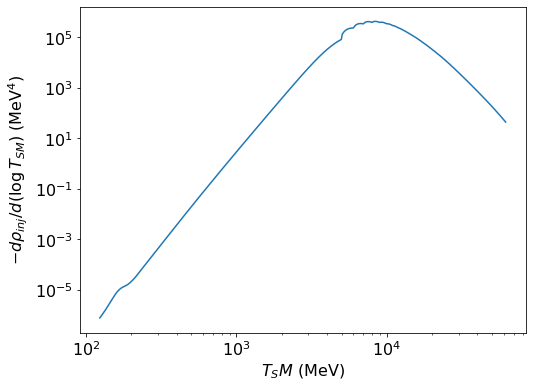

In [13]:
# Plot the SID energy injection rate
plt.figure(figsize=(8,6))
plt.loglog(T_SM_domain, -1*drho_dlogTSM)
plt.xlabel(r"$T_SM$ (MeV)")
plt.ylabel(r"$-d\rho_{inj} / d(\log T_{SM})$ (MeV$^4$)")
plt.show()

## Check the production rate of T_DS

In [2]:
dT_DS_dloga = []
T_DSs = [10, 20, 50]
for T_DS in T_DSs:
    dT_DS_dloga.append(ds.compute_dT_DS_dloga(T_DS, np.log(a_domain), ms1, ms2, theta, flavor, antineutrino, simplify))

NameError: name 'a_domain' is not defined

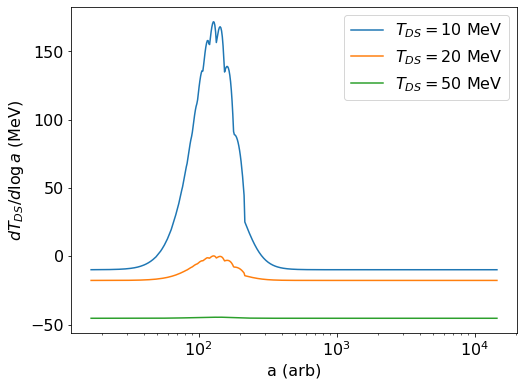

In [22]:
plt.figure(figsize=(8,6))

for i, T_DS in enumerate(T_DSs):
    plt.semilogx(a_domain, dT_DS_dloga[i], label=r'$T_{DS} = $'+str(T_DS)+' MeV')

plt.xlabel(r'a (arb)')
plt.ylabel(r'$dT_{DS} / d\log a$ (MeV)')
plt.legend()
plt.show()

## Solution

In [15]:
T_DS_initial = 0.01*ms1

T_DS_total = ds.compute_T_DS_vs_loga(a_domain, T_DS_initial, ms1, ms2, theta, flavor, antineutrino, simplify)

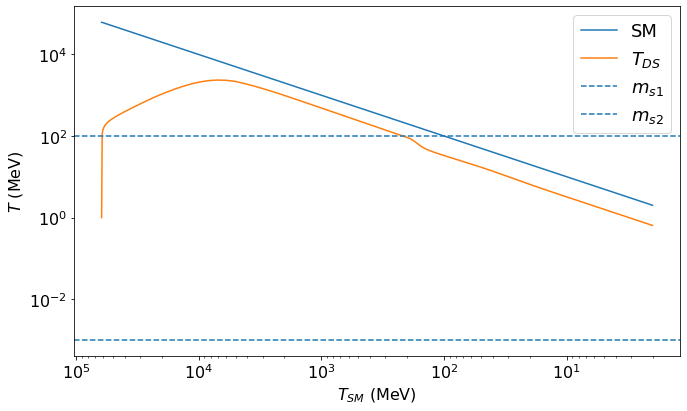

In [16]:
# Plot
plt.figure(figsize=(10, 6))
plt.loglog(T_SM_domain, T_SM_domain, label=r"SM")
plt.loglog(T_SM_domain, T_DS_total, label=r"$T_{DS}$")
plt.axhline(ms1, label=r"$m_{s1}$", linestyle="--")
plt.axhline(ms2, label=r"$m_{s2}$", linestyle="--")

plt.xlabel(r"$T_{SM}$ (MeV)")
plt.ylabel(r"$T$ (MeV)")
plt.tight_layout()
plt.gca().invert_xaxis()
plt.legend(fontsize=18)
plt.show()

# Attemping to use rho instead of T_DS

## Approximation: rho always redshifts like a^4

In [25]:
def compute_drho_DS_comoving_dloga(a, ms1, theta, flavor, antineutrino=False, simplify=False):
    """Compute the rate of change of the dark sector energy density with log scale factor
    - T_SM_func is a function that takes in a scale factor and returns the SM temperature
    - hubble_rate_func is a function that takes in T_SM and returns the hubble rate
    - Approximates that rho_DS is always relativistic
    """
    T_SM = ds.T_SM_func(a)
    drho_inj_dt = sid.compute_drho_injected_dt(T_SM, ms1, theta, flavor, antineutrino, simplify)

    return drho_inj_dt*a**4/ds.hubble_rate_func(T_SM)

def rho_DS_solve(a_i, a_f, ms1, theta, flavor, antineutrino=False, simplify=False, num_points=500):
    """Compute DS rho vs log scale factor using
    the covariant energy conservation equation. Assumes that rho_DS is always relativistic"""
    T_domain = np.logspace(np.log10(a_i), np.log10(a_f), num_points)
    rate = compute_drho_DS_comoving_dloga(a_domain, ms1, theta, flavor, antineutrino, simplify)
    result = integrate.cumtrapz(rate, np.log(a_domain), initial=0)
    return result/a_domain**4

## Check the production rate of T_DS

No handles with labels found to put in legend.


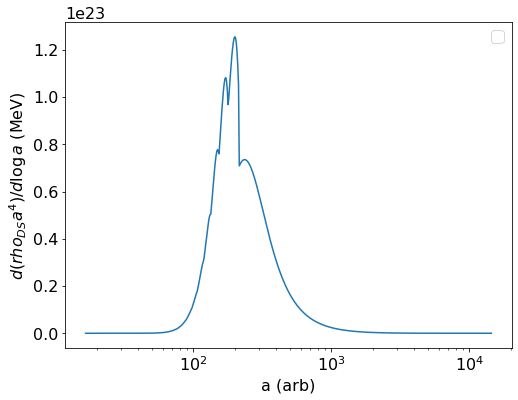

In [11]:
rate = compute_drho_DS_comoving_dloga(a_domain, ms1, theta, flavor, antineutrino, simplify)

plt.figure(figsize=(8,6))
plt.semilogx(a_domain, rate)

plt.xlabel(r'a (arb)')
plt.ylabel(r'$d(\rho_{DS} a^4) / d\log a$ (MeV)')
plt.legend()
plt.show()

## Solution

In [9]:
#Input parameters
theta = 0.5*10**-8
ms1 = 10**0
ms2 = 10**-3
flavor = 'electron'
antineutrino=False
simplify=False
Ti = min(10*sid.Tmax(ms1), 149*10**3)
Tfinal_integral = max(1, 0.002*sid.Tmax(ms1))
Tfinal = 2
T_SM_domain = np.logspace(np.log10(Ti), np.log10(Tfinal_integral), 500)
a_domain = ds.T_SM_to_a(T_SM_domain)

rho_DS_domain = ds.rho_DS_solve(a_domain, ms1, theta, flavor, antineutrino, simplify)

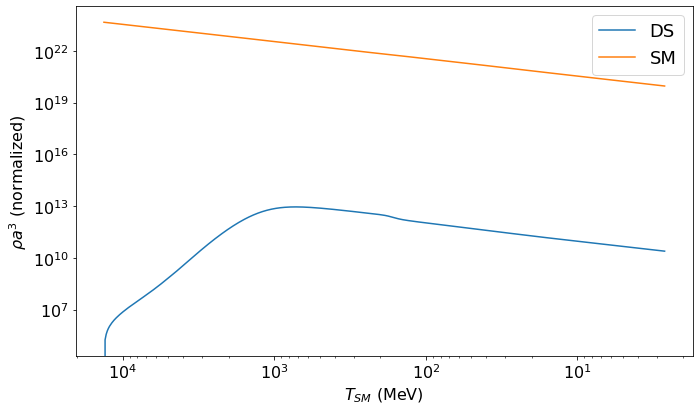

In [10]:
# get the SM energy density
rho_SM_domain = ds.energy_density_func(T_SM_domain)
norm = rho_SM_domain[-1]*a_domain[-1]**3

# Plot
plt.figure(figsize=(10, 6))
#plt.loglog(T_SM_domain, T_SM_domain, label=r"SM")
plt.loglog(T_SM_domain, rho_DS_domain*a_domain**3, label=r"DS")
plt.loglog(T_SM_domain, rho_SM_domain*a_domain**3, label=r"SM")

plt.xlabel(r"$T_{SM}$ (MeV)")
plt.ylabel(r"$\rho a^3$ (normalized)")
plt.tight_layout()
plt.gca().invert_xaxis()
plt.legend(fontsize=18)
plt.show()

## Convert rho_DS to T_DS

Not correct right now, doesn't conserve entropy

In [63]:
def find_temp_from_rho(rho, ms1, ms2):
    guess = (240*rho/(4*7*np.pi**2))**(1/4.) # 4 relativistic DOFs
    guess_2dof = (240*rho/(2*7*np.pi**2))**(1/4.)
    xmin, xmax = 0.1, 2
    
    if guess >= xmax*ms1:
        result = guess
        return guess, guess
    
    fun = lambda T: np.abs(2*sm.compute_energy_density(T, ms1, 1) + 2*sm.compute_energy_density(T, ms2, 1) - rho)
    if guess <= xmax*ms1 and guess >= xmin*ms1:
        result = optimize.minimize(fun, 1.05*guess)
        return result.x[0], guess

    if guess <= xmin*ms1 and guess >= xmax*ms2:
        return guess_2dof, guess_2dof # 2 relativistic DOFs

    if guess <= xmax*ms2 and guess_2dof > ms2:
        result = optimize.minimize(fun, guess_2dof)
        return result.x[0], guess
    else:
        return 0, 0 # if the temperature is below ms2: can't 

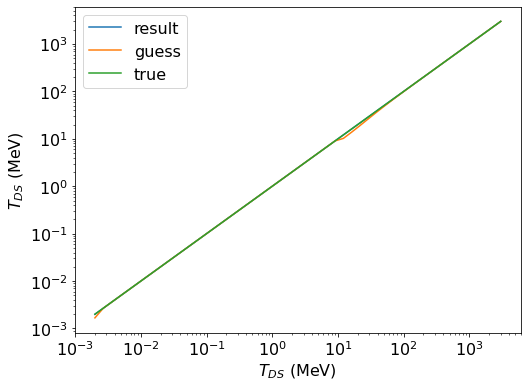

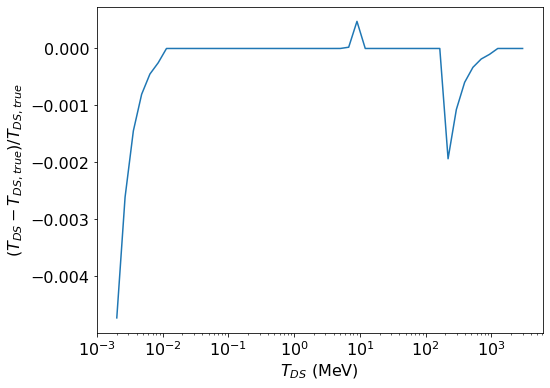

In [64]:
results, guesses = [], []
T_trues = np.logspace(np.log10(2*ms2), np.log10(30*ms1), 50)
for T_true in T_trues:
    rho_test = 2*sm.compute_energy_density(T_true, ms1, 1) + 2*sm.compute_energy_density(T_true, ms2, 1)
    result, guess = find_temp_from_rho(rho_test, ms1, ms2)
    results.append(result)
    guesses.append(guess)

# plot the results and guesses and the true values
plt.figure(figsize=(8,6))
plt.loglog(T_trues, results, label='result')
plt.loglog(T_trues, guesses, label='guess')
plt.loglog(T_trues, T_trues, label='true')
plt.xlabel(r'$T_{DS}$ (MeV)')
plt.ylabel(r'$T_{DS}$ (MeV)')
plt.legend()
plt.show()

# Plot the fractional difference between the result and the true value
plt.figure(figsize=(8,6))
plt.semilogx(T_trues, (results-T_trues)/T_trues)
plt.xlabel(r'$T_{DS}$ (MeV)')
plt.ylabel(r'$(T_{DS} - T_{DS, true}) / T_{DS, true}$')
plt.show()

# Compute Non-thermalized DS Evolution

In [2]:
# Parameters
theta = 0.5*np.sqrt(10**-15)
#ms = 10 #small coupling
ms = 1 #large coupling
flavor = 'electron'
antineutrino=False
simplify=False
Ti = min(30*sid.Tmax(ms), 149*10**3)
#Tf_integral = max(1, 0.001*sid.Tmax(ms))
Tf = 10**0
Tf_integral = Tf
T_domain = np.logspace(np.log10(Ti), np.log10(Tf_integral), 1000)

# Computation
y_domain = np.linspace(0.25, 5, 50)

fs_boltzmann = []
for y in y_domain:
    rate = sid.boltzmann_integrand_T(np.log(T_domain), y, Tf, theta, ms, flavor, antineutrino, simplify)
    result = [integrate.simpson(rate[:i+1], np.log(T_domain[:i+1])) for i in range(len(rate)-1)]
    # prepend zero
    result.insert(0, 0)
    fs_boltzmann.append(np.array(result))

# First index is y, second index is T
# T_DS_domain = (Tf*sid.SM_entropy_density(T_domain)/sid.SM_entropy_density(Tf))**(1./3)
poverT_domain = np.transpose([y_domain*Tf*(sid.SM_entropy_density(T_domain[i])/sid.SM_entropy_density(Tf))**(1./3) for i in range(len(T_domain))])/T_domain 
fs_boltzmann = np.array(fs_boltzmann)

# Compute beta: assumes a massless fermion, single DOF like is assumed for the fs_boltzmann computation
beta_domain = np.array([integrate.simpson(poverT_domain[:,i]**2*fs_boltzmann[:,i], x=poverT_domain[:,i])/(1.5*special.zeta(3)) for i in range(len(T_domain))])

# Compute the energy density in the DS
rho_DS_domain = np.array([(T_domain[i]**4/(2*np.pi))*integrate.simpson(poverT_domain[:,i]**2*fs_boltzmann[:,i]*np.sqrt(poverT_domain[:,i]**2+ms**2/T_domain[i]**2), x=poverT_domain[:,i]) for i in range(len(T_domain))])

# Compute the time dilation factor for poverT = 3
gamma = np.sqrt(1+(3*T_domain)**2/ms**2)
elapsed_time = np.zeros(len(T_domain))
elapsed_time[0] = 0
for i in range(1, len(T_domain)):
    elapsed_time[i] = (T_domain[i]-T_domain[i-1])/(sid.dTemperature_dtime(T_domain[i-1])) + elapsed_time[i-1]

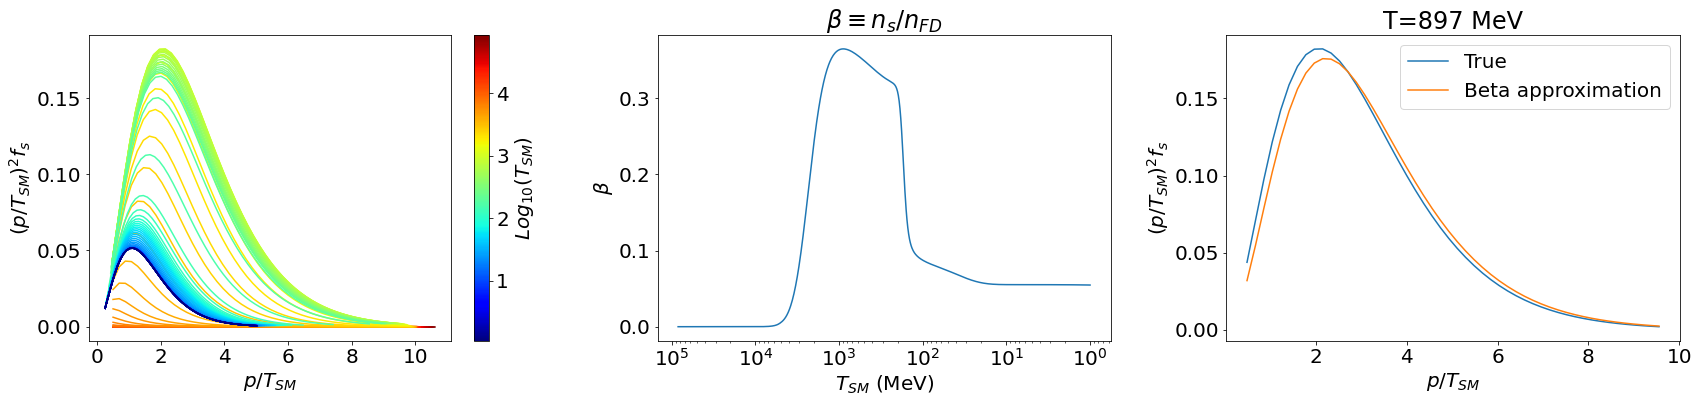

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(24,6)) # Adjust figsize as necessary

# Plot for fs_boltzmann
indices = np.arange(len(T_domain))[::10]
colors = cm.jet(np.linspace(1, 0, len(indices)))

for idx, color in zip(indices, colors):
    ax[0].plot(poverT_domain[:, idx], poverT_domain[:, idx]**2*fs_boltzmann[:, idx], color=color)
ax[0].set_xlabel(r'$p/T_{SM}$')
ax[0].set_ylabel(r'$(p/T_{SM})^2 f_s$')

norm = plt.Normalize(np.log10(T_domain[indices[0]]), np.log10(T_domain[indices[-1]]))
scalmap = plt.cm.ScalarMappable(cmap=cm.jet, norm=norm)
scalmap.set_array([])
cbar = fig.colorbar(scalmap, ax=ax[0], label=r'$Log_{10}(T_{SM})$')

# Plot for beta
ax[1].semilogx(T_domain, beta_domain)
#ax[1].semilogx(T_domain, rho_beta)
ax[1].set_title(r'$\beta \equiv n_{s}/n_{FD}}$')
ax[1].set_ylabel(r'$\beta$')
ax[1].set_xlabel(r'$T_{SM}$ (MeV)')
ax[1].invert_xaxis()

# Plot for single fs at a moment in time
T_idx = 400
ax[2].set_title(f'T={T_domain[T_idx]:.3g} MeV')
ax[2].plot(poverT_domain[:, T_idx], poverT_domain[:, T_idx]**2*fs_boltzmann[:, T_idx], label='True')
ax[2].plot(poverT_domain[:, T_idx], beta_domain[T_idx]*poverT_domain[:, T_idx]**2/(np.exp(poverT_domain[:, T_idx])+1), label=f'Beta approximation')
ax[2].legend()
ax[2].set_xlabel(r'$p/T_{SM}$')
ax[2].set_ylabel(r'$(p/T_{SM})^2 f_s$')

plt.tight_layout()
plt.savefig("test.png")
plt.show()

### Small Coupling

#### stacked plots

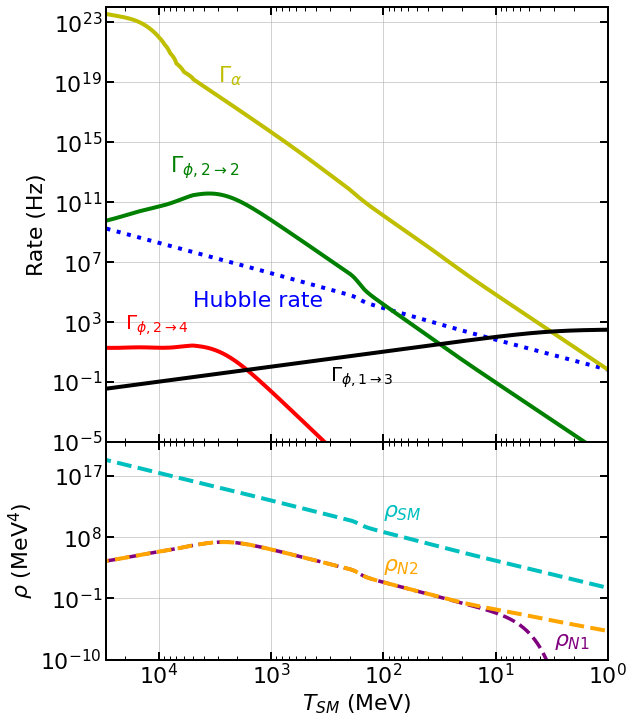

In [5]:
Gphi_over_Gf = 10
x_min, x_max = 3*10**4, 1

exponent = ds.sterile_decay_rate(ms, Gphi_over_Gf, numerical_factor=1)*elapsed_time/gamma
rho_s1 = 0.5*rho_DS_domain*np.exp(-exponent) # assume both are always relativistic, ignore time dependence of gamma
rho_s2 = rho_DS_domain-rho_s1 # assume both are always relativistic


# Create a figure and a 1x2 subplot grid with different heights and shared x-axis
fig, ax = plt.subplots(2, 1, figsize=(9, 12), gridspec_kw={'height_ratios': [1, 0.5]}, sharex=True)
fig.subplots_adjust(hspace=0)

# Plot data on the first subplot (ax[0])
ax[0].loglog(T_domain, ds.hubble_rate_func(T_domain)*c.MeVtoHz, c='b', linewidth=4, ls='dotted', label='Hubble rate')
ax[0].annotate('Hubble rate', (5*10**3, 10**4), fontsize=22, c='b', rotation=0)
ax[0].loglog(T_domain, sid.active_scattering_rate(3*T_domain, T_domain, flavor)*c.MeVtoHz, c='y', linewidth=4, label=r'$\Gamma_\alpha$')
ax[0].annotate(r'$\Gamma_\alpha$', (3*10**3, 10**19), fontsize=22, c='y', rotation=0)
ax[0].loglog(T_domain, ds.gamma_s_2to2(3*T_domain, T_domain, beta_domain, Gphi_over_Gf)*c.MeVtoHz, c='g', linewidth=4, label=r'$\Gamma_{\phi,2 \rightarrow 2}$')
ax[0].annotate(r'$\Gamma_{\phi,2 \rightarrow 2}$', (8*10**3, 10**13), fontsize=22, c='g', rotation=0)
ax[0].loglog(T_domain, ds.gamma_s_2to4(3*T_domain, T_domain, beta_domain, Gphi_over_Gf)*c.MeVtoHz, linewidth=4, c='r', label=r'$\Gamma_{s,2to4}^{approx}$')
ax[0].annotate(r'$\Gamma_{\phi,2 \rightarrow 4}$', (2*10**4, 3*10**2), fontsize=20, c='r', rotation=0)
ax[0].loglog(T_domain, ds.sterile_decay_rate(ms, Gphi_over_Gf, numerical_factor=1)*c.MeVtoHz/gamma, linewidth=4, c='k', label=r'$\Gamma_{s, 1to3}^{approx}$')
ax[0].annotate(r'$\Gamma_{\phi, 1 \rightarrow 3}$', (3*10**2, 10**-1), fontsize=20, c='k', rotation=0)
ax[0].invert_xaxis()
ax[0].set_ylabel(r'Rate (Hz)')
ax[0].set_ylim(10.**-5, 10.**24)
ax[0].set_xlim(x_min, x_max)

# Plot data on the second subplot (ax[1])
ax[1].loglog(T_domain, ds.energy_density_func(T_domain), c='c', ls='--', linewidth=4)
ax[1].annotate(r'$\rho_{SM}$', (10**2, 10**11), fontsize=22, c='c', rotation=0)
ax[1].loglog(T_domain, rho_s1, c='purple', linewidth=3.5, ls='--')
ax[1].annotate(r'$\rho_{N1}$', (3, 10**-8), fontsize=22, c='purple', rotation=0)
ax[1].loglog(T_domain, rho_s2, c='orange', linewidth=4, ls='--')
ax[1].annotate(r'$\rho_{N2}$', (10**2, 10**3), fontsize=22, c='orange', rotation=0)
ax[1].invert_xaxis()
ax[1].set_ylabel(r'$\rho$ (MeV$^4$)')
ax[1].set_xlabel(r'$T_{SM}$ (MeV)')
ax[1].set_xlim(x_min, x_max)
ax[1].set_ylim(10**-10, 10.**22)

# Change the thickness of the plot frame
for axis in ax:
    axis.spines['top'].set_linewidth(2)     # Top spine
    axis.spines['right'].set_linewidth(2)   # Right spine
    axis.spines['bottom'].set_linewidth(2)  # Bottom spine
    axis.spines['left'].set_linewidth(2)    # Left spine
    axis.tick_params(axis='both', which='major', direction='in', width=2, length=8, top=True, right=True)
    axis.tick_params(axis='both', which='minor', direction='in', width=1, length=4, top=True, right=True)
    axis.grid(which='major', alpha=0.7)

plt.savefig("plots/no2to4_example.pdf", bbox_inches='tight')
plt.show()

#### Side by side plots

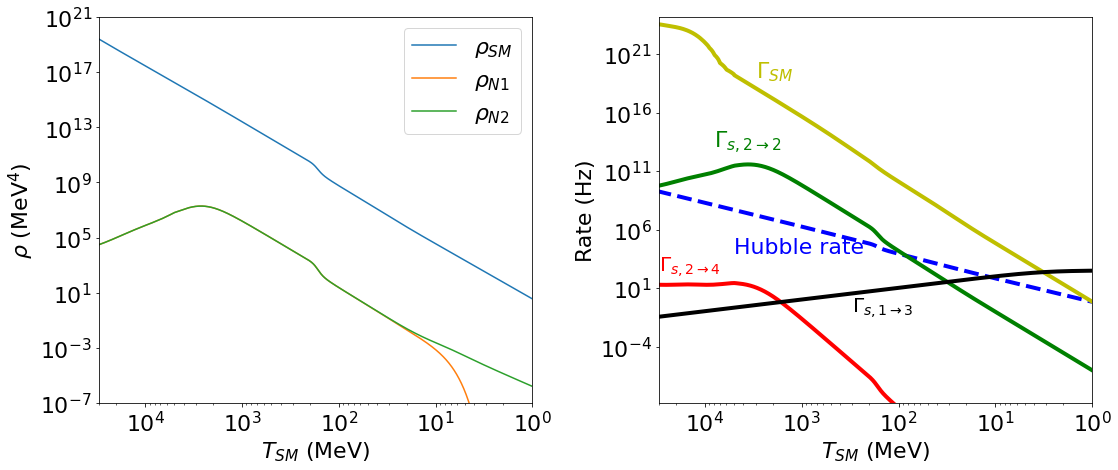

In [95]:
Gphi_over_Gf = 10
x_min, x_max = 3*10**4, 1

exponent = ds.sterile_decay_rate(ms, Gphi_over_Gf, numerical_factor=1)*elapsed_time/gamma
rho_s1 = 0.5*rho_DS_domain*np.exp(-exponent) # assume both are always relativistic, ignore time dependence of gamma
rho_s2 = rho_DS_domain-rho_s1 # assume both are always relativistic

# Create a figure and a 1x2 subplot grid
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# Plot data on the first subplot
ax[0].loglog(T_domain, ds.energy_density_func(T_domain), label=r'$\rho_{SM}$')
ax[0].loglog(T_domain, rho_s1, label=r'$\rho_{N1}$')
ax[0].loglog(T_domain, rho_s2, label=r'$\rho_{N2}$')
ax[0].invert_xaxis()
ax[0].set_xlabel(r'$T_{SM}$ (MeV)')
ax[0].set_ylabel(r'$\rho$ (MeV$^4$)')
#ax[0].axvline(ms/3, linestyle='--', color='k', label=r'3T=$m_{s1}$')
ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(10**-7, 10.**21)
ax[0].legend()

# Plot data on the second subplot
ax[1].loglog(T_domain, ds.hubble_rate_func(T_domain)*c.MeVtoHz, c='b', linewidth=4, ls='--')
plt.annotate('Hubble rate', (5*10**3, 10**4), fontsize=22, c='b', rotation=0)
ax[1].loglog(T_domain, sid.active_scattering_rate(3*T_domain, T_domain, flavor)*c.MeVtoHz, c='y', linewidth=4)
plt.annotate(r'$\Gamma_\alpha$', (3*10**3, 10**19), fontsize=22, c='y', rotation=0)
ax[1].loglog(T_domain, ds.gamma_s_2to2(3*T_domain, T_domain, beta_domain, Gphi_over_Gf)*c.MeVtoHz, c='g', linewidth=4, label=r'$\Gamma_{\phi,2 \rightarrow 2}$')
plt.annotate(r'$\Gamma_{\phi,2 \rightarrow 2}$', (8*10**3, 10**13), fontsize=22, c='g', rotation=0)
ax[1].loglog(T_domain, ds.gamma_s_2to4(3*T_domain, T_domain, beta_domain, Gphi_over_Gf)*c.MeVtoHz, linewidth=4, c='r', label=r'$\Gamma_{s,2to4}^{approx}$')
plt.annotate(r'$\Gamma_{\phi,2 \rightarrow 4}$', (3*10**4, 3*10**2), fontsize=20, c='r', rotation=0)
ax[1].loglog(T_domain, ds.sterile_decay_rate(ms, Gphi_over_Gf, numerical_factor=1)*c.MeVtoHz/gamma, linewidth=4, c='k', label=r'$\Gamma_{s, 1to3}^{approx}$')
plt.annotate(r'$\Gamma_{\phi, 1 \rightarrow 3}$', (3*10**2, 10**-1), fontsize=20, c='k', rotation=0)
ax[1].invert_xaxis()
ax[1].set_xlabel(r'$T_{SM}$ (MeV)')
ax[1].set_ylabel(r'Rate (Hz)')
ax[1].set_ylim(10**-30*c.MeVtoHz, 10**3*c.MeVtoHz)
ax[1].set_xlim(x_min, x_max)

# Adjust the space between the subplots
plt.tight_layout()

# Display the figure
plt.show()

### Large Coupling

#### Side by side

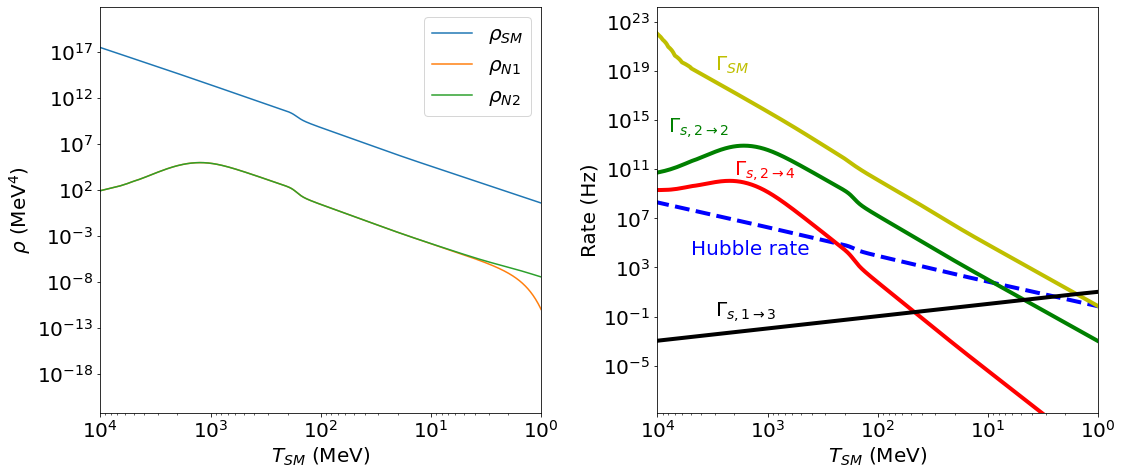

In [14]:
Gphi_over_Gf = 1000
x_min, x_max = 10**4, 1

# Create a figure and a 1x2 subplot grid
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# Plot data on the first subplot
ax[0].loglog(T_domain, ds.energy_density_func(T_domain), label=r'$\rho_{SM}$')
ax[0].loglog(T_domain, rho_s1, label=r'$\rho_{N1}$')
ax[0].loglog(T_domain, rho_s2, label=r'$\rho_{N2}$')
ax[0].invert_xaxis()
#ax[0].set_title('Standard DW (No 2nd sterile)')
ax[0].set_xlabel(r'$T_{SM}$ (MeV)')
ax[0].set_ylabel(r'$\rho$ (MeV$^4$)')
#ax[0].axvline(ms/3, linestyle='--', color='k', label=r'3T=$m_{s1}$')
ax[0].set_xlim(x_min, x_max)
ax[0].legend()

# Plot data on the second subplot
ax[1].loglog(T_domain, ds.hubble_rate_func(T_domain)*c.MeVtoHz, c='b', linewidth=4, ls='--')
plt.annotate('Hubble rate', (5*10**3, 10**4), fontsize=20, c='b', rotation=0)
ax[1].loglog(T_domain, sid.active_scattering_rate(3*T_domain, T_domain, flavor)*c.MeVtoHz, c='y', linewidth=4)
plt.annotate(r'$\Gamma_\alpha$', (3*10**3, 10**19), fontsize=20, c='y', rotation=0)
ax[1].loglog(T_domain, ds.gamma_s_2to2(3*T_domain, T_domain, beta_domain, Gphi_over_Gf)*c.MeVtoHz, c='g', linewidth=4, label=r'$\Gamma_{\phi,2 \rightarrow 2}$')
plt.annotate(r'$\Gamma_{\phi,2 \rightarrow 2}$', (8*10**3, 10**14), fontsize=20, c='g', rotation=0)
ax[1].loglog(T_domain, ds.gamma_s_2to4(3*T_domain, T_domain, beta_domain, Gphi_over_Gf)*c.MeVtoHz, linewidth=4, c='r', label=r'$\Gamma_{s,2to4}^{approx}$')
plt.annotate(r'$\Gamma_{\phi,2 \rightarrow 4}$', (2*10**3, 3*10**10), fontsize=20, c='r', rotation=0)
ax[1].loglog(T_domain, ds.sterile_decay_rate(ms, Gphi_over_Gf, numerical_factor=1)*c.MeVtoHz/gamma, linewidth=4, c='k', label=r'$\Gamma_{s, 1to3}^{approx}$')
plt.annotate(r'$\Gamma_{\phi, 1 \rightarrow 3}$', (3*10**3, 10**-1), fontsize=20, c='k', rotation=0)
ax[1].invert_xaxis()
ax[1].set_xlabel(r'$T_{SM}$ (MeV)')
ax[1].set_ylabel(r'Rate (Hz)')
ax[1].set_ylim(10**-30*c.MeVtoHz, 10**3*c.MeVtoHz)
ax[1].set_xlim(x_min, x_max)

# Adjust the space between the subplots
plt.tight_layout()

# Display the figure
plt.show()

#### Stacked on Top

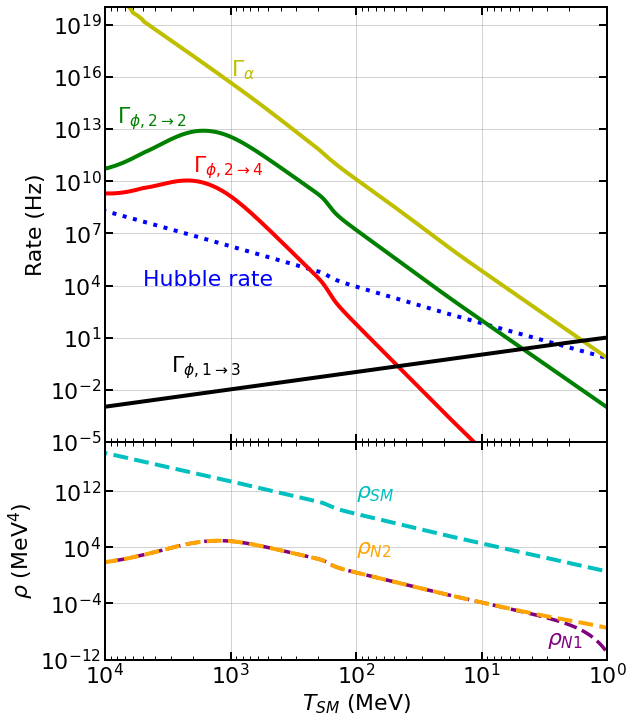

In [5]:
Gphi_over_Gf = 1000
x_min, x_max = 10**4, 1

# Get the sterile densities after decay
T_DS = (240*rho_DS_domain/(4*7*np.pi**2))**(1./4) + 1e-5 #only works when both steriles are thermalized and relativistic
elapsed_time = np.zeros(len(T_domain))
elapsed_time[0] = 0
for i in range(1, len(T_domain)):
    elapsed_time[i] = (T_domain[i]-T_domain[i-1])/(sid.dTemperature_dtime(T_domain[i-1])) + elapsed_time[i-1]

exponent = ds.sterile_decay_rate(ms, Gphi_over_Gf, numerical_factor=1)*elapsed_time/gamma
rho_s1 = 2*np.array([sm.compute_energy_density(T, 0, 1) for T in T_DS])*np.exp(-exponent) # assume both are always relativistic, ignore time dependence of gamma
rho_s2 = 4*np.array([sm.compute_energy_density(T, 0, 1) for T in T_DS])-rho_s1 # assume both are always relativistic

# Create a figure and a 1x2 subplot grid with different heights and shared x-axis
fig, ax = plt.subplots(2, 1, figsize=(9, 12), gridspec_kw={'height_ratios': [1, 0.5]}, sharex=True)
fig.subplots_adjust(hspace=0)

# Plot data on the first subplot (ax[0])
ax[0].loglog(T_domain, ds.hubble_rate_func(T_domain)*c.MeVtoHz, c='b', linewidth=4, ls='dotted', label='Hubble rate')
ax[0].annotate('Hubble rate', (5*10**3, 10**4), fontsize=22, c='b', rotation=0)
ax[0].loglog(T_domain, sid.active_scattering_rate(3*T_domain, T_domain, flavor)*c.MeVtoHz, c='y', linewidth=4, label=r'$\Gamma_\alpha$')
ax[0].annotate(r'$\Gamma_\alpha$', (10**3, 10**16), fontsize=22, c='y', rotation=0)
ax[0].loglog(T_domain, ds.gamma_s_2to2(3*T_domain, T_domain, beta_domain, Gphi_over_Gf)*c.MeVtoHz, c='g', linewidth=4, label=r'$\Gamma_{\phi,2 \rightarrow 2}$')
ax[0].annotate(r'$\Gamma_{\phi,2 \rightarrow 2}$', (8*10**3, 2*10**13), fontsize=22, c='g', rotation=0)
ax[0].loglog(T_domain, ds.gamma_s_2to4(3*T_domain, T_domain, beta_domain, Gphi_over_Gf)*c.MeVtoHz, linewidth=4, c='r', label=r'$\Gamma_{s,2to4}^{approx}$')
ax[0].annotate(r'$\Gamma_{\phi,2 \rightarrow 4}$', (2*10**3, 3*10**10), fontsize=22, c='r', rotation=0)
ax[0].loglog(T_domain, ds.sterile_decay_rate(ms, Gphi_over_Gf, numerical_factor=1)*c.MeVtoHz/gamma, linewidth=4, c='k', label=r'$\Gamma_{s, 1to3}^{approx}$')
ax[0].annotate(r'$\Gamma_{\phi, 1 \rightarrow 3}$', (3*10**3, 10**-1), fontsize=22, c='k', rotation=0)
ax[0].invert_xaxis()
ax[0].set_ylabel(r'Rate (Hz)')
ax[0].set_ylim(10.**-5, 10.**20)
ax[0].set_xlim(x_min, x_max)

# Plot data on the second subplot (ax[1])
ax[1].loglog(T_domain, ds.energy_density_func(T_domain), c='c', ls='--', linewidth=4)
ax[1].annotate(r'$\rho_{SM}$', (10**2, 10**11), fontsize=22, c='c', rotation=0)
ax[1].loglog(T_domain, rho_s1, c='purple', linewidth=3.5, ls='--')
ax[1].annotate(r'$\rho_{N1}$', (3, 10**-10), fontsize=22, c='purple', rotation=0)
ax[1].loglog(T_domain, rho_s2, c='orange', linewidth=4, ls='--')
ax[1].annotate(r'$\rho_{N2}$', (10**2, 10**3), fontsize=22, c='orange', rotation=0)
ax[1].invert_xaxis()
ax[1].set_ylabel(r'$\rho$ (MeV$^4$)')
ax[1].set_xlabel(r'$T_{SM}$ (MeV)')
ax[1].set_xlim(x_min, x_max)
ax[1].set_ylim(10.**-12, 10.**19)

# Change the thickness of the plot frame
for axis in ax:
    axis.spines['top'].set_linewidth(2)     # Top spine
    axis.spines['right'].set_linewidth(2)   # Right spine
    axis.spines['bottom'].set_linewidth(2)  # Bottom spine
    axis.spines['left'].set_linewidth(2)    # Left spine
    axis.tick_params(axis='both', which='major', direction='in', width=2, length=8, top=True, right=True)
    axis.tick_params(axis='both', which='minor', direction='in', width=1, length=4, top=True, right=True)
    axis.grid(which='major', alpha=0.7)

plt.savefig("plots/thermalization_example.pdf", bbox_inches='tight')
plt.show()